In [1]:
# Python 3.7
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

db = pd.read_hdf("moreoptiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
N0 = db[db['Now'] == '2018-05-28 14:50:00']
M0 = N0[N0['Maturity'] == '2018-06-15 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

<IPython.core.display.Javascript object>


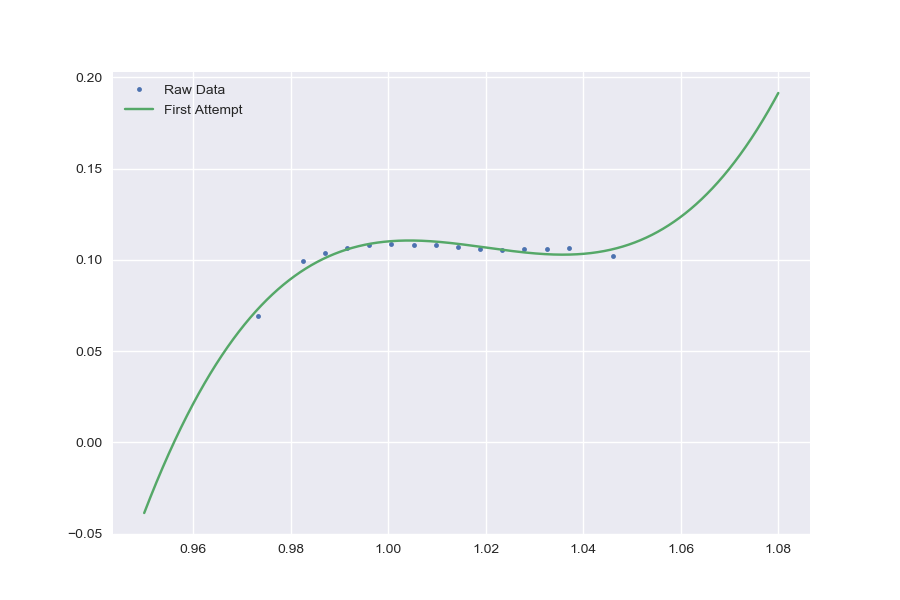

In [3]:
p = np.poly1d(np.polyfit(M0['Moneyness'], M0['CallImpVol'], 3))

xp = np.linspace(0.95, 1.08, 4310)

plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.legend()
plt.show()

In [4]:
M0 = db[db['Maturity'] == '2018-06-15 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

<IPython.core.display.Javascript object>


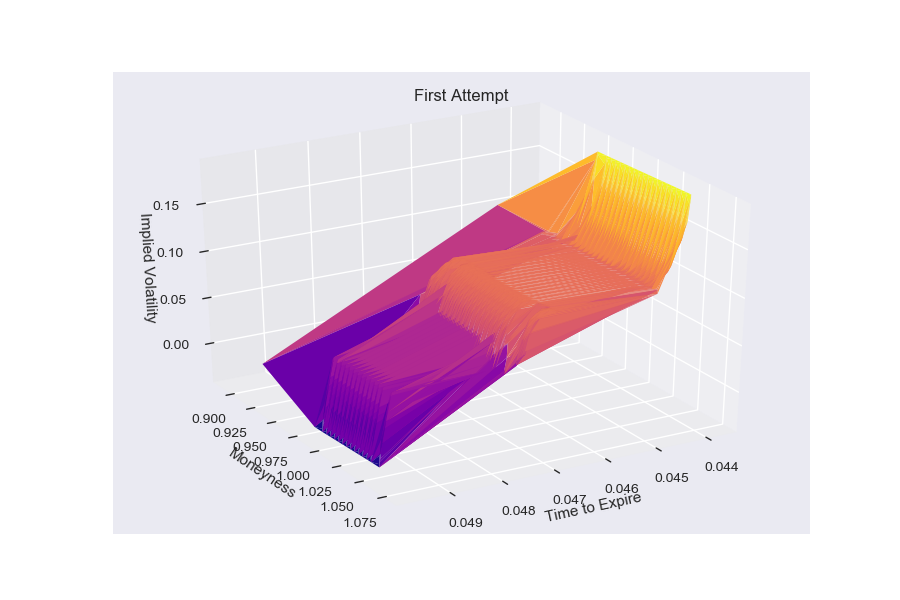

In [5]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(M0['Expiration'], M0['Moneyness'], p(xp), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Time to Expire')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 60)
plt.title('First Attempt')
plt.show()

<IPython.core.display.Javascript object>


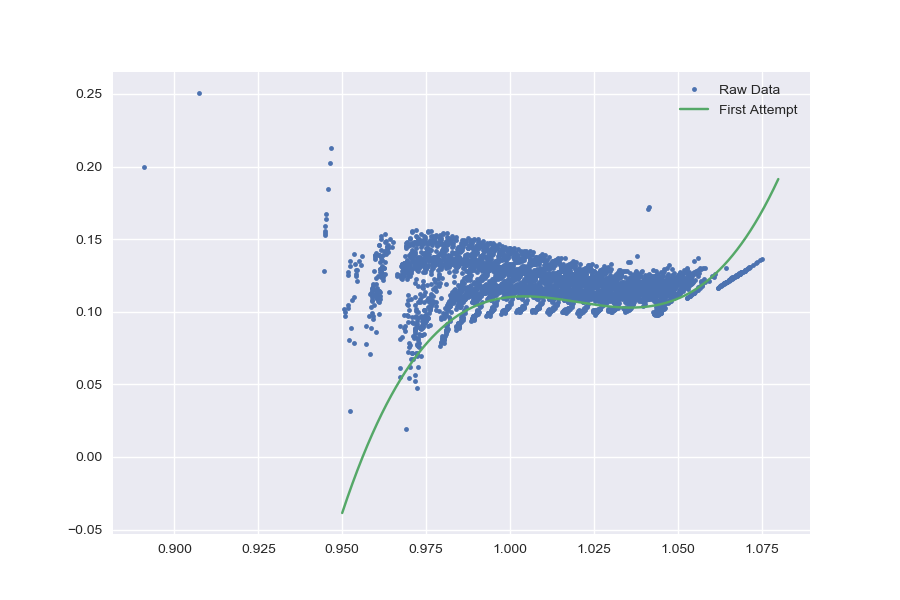

In [6]:
plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.legend()
plt.show()

So obviously implied volatility is related to the moneyness of the contracts but that's not the only driver, maturity also plays an important role, as they move closer to it, they gain leverage and thats also displayed on the implied volatility. This polynomial also seems to exarcebate the implied volatility of the deeper in & out of the money contracts

In [7]:
splinterp = Rbf(M0['Moneyness'], M0['Expiration'], M0['CallImpVol'], function='cubic', smooth=0)
rbffit = splinterp(M0['Moneyness'], M0['Expiration'])

To incorporate that, we'll will have to use a multivariate (3d) polynomial fit or a multivariate spline interpolation, here we utilize the radial basis function to perform the latter, despite not having an appropriate sample to describe the effects of time on the implied volatility since that would require at least 1 month of option data

<IPython.core.display.Javascript object>


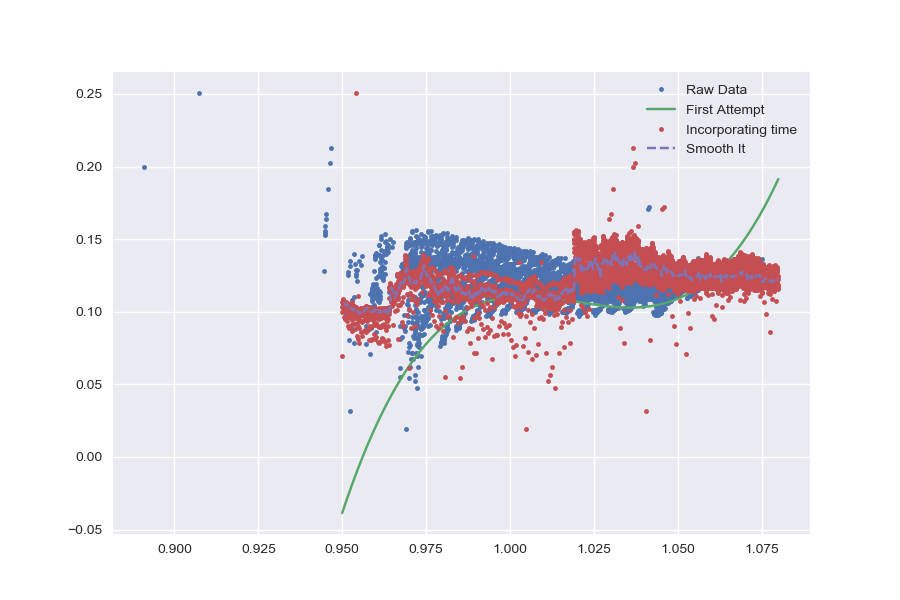

In [8]:
plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.plot(xp, rbffit, '.', label='Incorporating time')
plt.plot(xp, pd.Series(rbffit).rolling(window=20).median(), '--', label='Smooth It')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


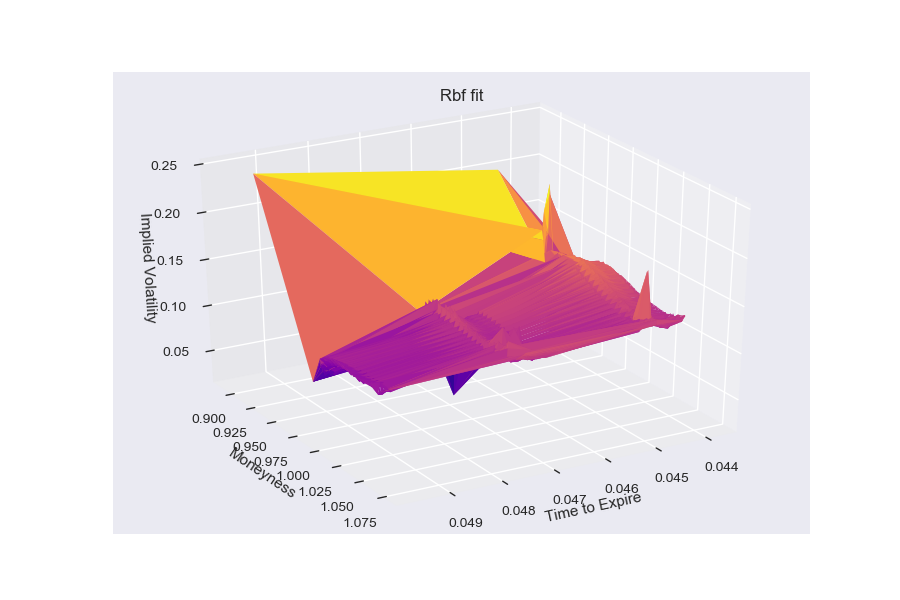

In [9]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(M0['Expiration'], M0['Moneyness'], rbffit, cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Time to Expire')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')

ax.dist=12
ax.view_init(30, 60)
plt.title('Rbf fit')
plt.show()

Like I suspetected, it wasn't a good idea to add the time dimension here since the database has only 2 days of data, it overfitted the model but definitly plays a role, specially near maturity 